# Table of Contents
* [THOR dense ds](#THOR-dense-ds)
* [build concordance ds](#build-concordance-ds)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
from tqdm import tqdm as tqdm
from collections import defaultdict
from collections import Counter
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

import os
import cv2
from copy import deepcopy
import PIL.Image as Image
from tqdm import tqdm

import ai2thor.controller
import pickle
import json
import random


controller = ai2thor.controller.Controller()
controller.start()

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

# THOR dense ds

In [62]:
def get_reachable_pos(scene_id):
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.25, fieldOfView=42.5))
    meta_event = controller.step(dict(action='GetReachablePositions'))
    return meta_event.metadata['reachablePositions']


def take_image_w_md(event, img_name=None, img_path='concord_ds/sim/'):
    all_md = event.metadata
    relevant_md = {
        'cameraPosition': all_md['cameraPosition'],
        'agentPosition': all_md['agent']['position'],
        'agentRotation': all_md['agent']['rotation']['y'],
    }
    x, z = [round(relevant_md['agentPosition'][co], 2) for co in ['x', 'z']]
    rot = round(relevant_md['agentRotation'], 2)
    if not img_name:
        img_name = f'img_{x}_{z}_{rot}'.replace('.', 'p') + '.png'
    relevant_md['imageName'] = img_name
    save_image(event, img_name, img_path)
    return relevant_md

def inflate_neighborhood(pos):
    meta_event = controller.step(dict(action='Initialize', gridSize=0.05, fieldOfView=42.5))
    trans_dists = [0.05, -0.05]
    rot_ang = 5
    event = controller.step(action='TeleportFull', x=pos['x'], y=pos['y'], z=pos['z'], rotation=pos['rotation'])
    orig_pos_md = take_image_w_md(event)
    neighbors_md = []
    for co in ['x', 'z']:
        for td in trans_dists:
            trans_pos = deepcopy(pos)
            trans_pos[co] = pos[co] + td
            trans_pos['rotation'] = orig_pos_md['agentRotation']
            trans_md = teleport(trans_pos)
            if not trans_md:
                continue
            neighbors_md.append(take_image_w_md(trans_md))
    for i in range(-2, 2):
        if i == 0:
            continue
        trans_pos = deepcopy(pos)
        trans_pos['rotation'] = orig_pos_md['agentRotation'] + i * rot_ang
        trans_md = teleport(trans_pos)
        if not trans_md:
            continue
        neighbors_md.append(take_image_w_md(trans_md))
    return orig_pos_md, neighbors_md

def teleport(pos):
    rot = pos.get('rotation', 0)
    new_pos = controller.step(action='TeleportFull', x=pos['x'], y=pos['y'], z=pos['z'], rotation=rot)
    if not new_pos.metadata['lastActionSuccess']:
        print(new_pos.metadata['errorMessage'])
        return False
    return new_pos


def save_image(event, img_name, img_path='concord_ds/sim/'):
    img_arr = event.cv2img
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img_arr)
    img.save(os.path.join(img_path, img_name))

    
def build_img_neigh_ds(all_pos):
    sim_img_neigborhood = []
#     for pos in all_pos[:3]:
    for pos in tqdm(all_pos):
        orig_md, neigh_md = inflate_neighborhood(pos)
        sim_img_neigborhood.append({'grid_loc': orig_md, 'neighbors': neigh_md})
    return sim_img_neigborhood


def build_img_exact(all_pos):
    detections = {}
    for idx, pos in enumerate(all_pos):
        print(idx)
        orig_md, neigh_md = inflate_neighborhood(pos)
        meta_event = controller.step(dict(action='Initialize', gridSize=0.05, fieldOfView=42.5, renderClassImage=True, renderObjectImage=True))
        event = controller.step(action='TeleportFull', x=pos['x'], y=pos['y'], z=pos['z'], rotation=pos['rotation'])
        det = event.class_detections2D
        detections[img_name_lookup[idx]] = det
#         take_image_w_md(event, img_name=img_name_lookup[idx] + '.jpg', img_path='concord_ds/sim_exact/')
    return detections

In [63]:
simdets = build_img_exact(all_real_pos)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [86]:
with open("raw_simdets.pkl", 'wb') as f:
        pickle.dump(simdets, f)

In [84]:
simdets

{'12133200647376': {'wall_panel_32_5 (12)': [array([  0,   1,  40, 300])],
  'Sofa': [array([  0, 137, 299, 300])],
  'Pillow': [array([291, 211, 299, 234])],
  'wall_panel_32_5 (11)': [array([ 41,   1, 239, 216])],
  'wall_panel_32_5 (10)': [array([240,   1, 299, 138])]},
 '12133204608805': {'Sofa': [array([  0, 137, 299, 300])],
  'Pillow': [array([246, 203, 299, 254])],
  'wall_panel_32_5 (11)': [array([  0,   1, 195, 213])],
  'wall_panel_32_5 (10)': [array([196,   1, 299, 139])]},
 '12133208004621': {'Sofa': [array([  0, 138, 299, 300])],
  'Pillow': [array([203, 200, 299, 255])],
  'wall_panel_32_5 (10)': [array([154,   1, 299, 139])],
  'wall_panel_32_5 (11)': [array([  0,   1, 153, 138])]},
 '12133211323603': {'Sofa': [array([  0, 138, 299, 300])],
  'Pillow': [array([165, 198, 299, 252])],
  'wall_panel_32_5 (26)': [array([283,   1, 299, 194])],
  'wall_panel_32_5 (10)': [array([116,   1, 282, 140])],
  'wall_panel_32_5 (11)': [array([  0,   1, 115, 138])]},
 '12133214515886':

In [576]:
te1.class_detections2D

{}

In [577]:
neigh_ds.class_detections2D

{}

In [455]:
# scene_id = 'FloorPlan_RVal2_2'
# all_orig_pos = get_reachable_pos(scene_id)

# neigh_ds = build_img_neigh_ds(all_orig_pos)

# build_img_neigh_ds(all_orig_pos)

# build concordance ds

In [48]:
def real2sim_pos(real_pos):
    real_vec = np.array([[real_pos['x']],
                         [real_pos['z']],
                         [1]])

    # affine matrix transformer
#     A = np.array([[ 0.94237916,  0.0165435 ,  0.85515405],
#                   [-0.01759903,  0.91987387, -1.1198701 ]])
    
    A = np.array([[ 1.00854301, -0.0111386 ,  0.51920809],
                   [ 0.00316833,  0.97336625, -1.15532594]])

    s = np.dot(A, real_vec).reshape(-1)
    real_pos['x'] = s[0] 
    real_pos['z'] = s[1]
    return real_pos

def get_sim_coords(real_md):
    real_pos = {**real_md['agent']['position'], 'rotation': real_md['agent']['rotation']}
    real_pos['z'] = real_pos['y']
    real_pos['y'] = 0.83
    sim_corr = real2sim_pos(real_pos)
    return sim_corr

def load_real_img(img_n):
    img_path = f'{base_dir}/images/{img_n}.jpg'
    img = Image.open(img_path)
    return img


def get_thor_img_at_real_loc(scene_id, real_md):
    sim_corr = get_sim_coords(real_md)
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.05, fieldOfView=42.5, renderClassImage=True, renderObjectImage=True))
    sim_pos = teleport(sim_corr)
    img_arr = sim_pos.cv2img
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img_arr)
    return img, sim_pos


def show_side_by_side(real_img, sim_img):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(real_img)
    axarr[1].imshow(sim_img)
    axarr[0].axis('off')
    axarr[1].axis('off')

In [5]:
scene_id = 'FloorPlan_RVal2_2'

base_dir = '/Users/schwenk/wrk/transfer/updated_metadata_collection/'

with open (base_dir + 'metadata.pickle', 'rb') as f:
    real_md = pickle.load(f)

In [6]:
spec_n = '12225521533719'
spec_loc = real_md[spec_n]

In [7]:
spec_loc

{'agent': {'position': {'y': -2.11, 'x': 2.7},
  'rotation': 90.60999987931916,
  'cameraHorizon': 0.5273437513344635},
 'scene': 'Val2_2'}

In [8]:
img_name_lookup = list(real_md.keys())

In [55]:
all_real_pos = [get_sim_coords(im) for im in real_md.values()]
# all_real_pos = [get_sim_coords(im) for im in [spec_loc]]

In [478]:
neigh_ds = build_img_neigh_ds(all_real_pos)

100%|██████████| 846/846 [11:58<00:00,  1.45it/s]


In [460]:
len(neigh_ds)

846

In [480]:
real_ds = []
for img_n, md in real_md.items():
    dp = {
        'imageName': f'{img_n}.jpg',
        **md['agent']
    }
    dp['position'] = get_sim_coords(md)
    real_ds.append(dp)

In [479]:
with open('val_2_2_neigborhood_ds.json', 'w') as f:
    json.dump(neigh_ds, f, indent=3, sort_keys=True)

In [481]:
with open('val_2_2_real_concord_ds.json', 'w') as f:
    json.dump(real_ds, f, indent=3, sort_keys=True)

In [579]:
# img_n, real_img_md = spec_n, spec_loc
# real_img = load_real_img(img_n)

# sim_img, debug_simp = get_thor_img_at_real_loc(scene_id, real_img_md)

# show_side_by_side(real_img, sim_img)

In [112]:
debug_simp.instance_detections2D

{'CoffeeTable|+08.00|+00.00|-01.31': array([ 95, 203, 189, 300]),
 'FloorLamp|+08.65|+00.00|-01.25': array([109,  27, 145, 251]),
 'ArmChair|+09.30|+00.00|-01.46': array([103, 147, 189, 247]),
 'BaseballBat|+07.79|+00.46|-01.43': array([152, 208, 167, 223]),
 'DeskLamp|+07.73|+00.46|-01.18': array([107, 139, 148, 222]),
 'Book|+08.21|+00.46|-01.39': array([126, 202, 170, 210]),
 'Vase|+08.35|+00.46|-01.20': array([112, 173, 128, 204])}

In [113]:
def get_objects_vis(sim_point):
    exclude_strings = ['wall_', 'floor', 'ceiling']
    instances = sim_point.instance_detections2D
    return len(instances)

In [114]:
get_objects_vis(debug_simp)

7

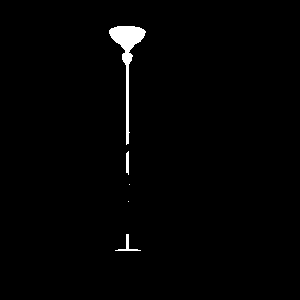

In [101]:
Image.fromarray(class_masks)

In [99]:
class_masks = debug_simp.class_masks['FloorLamp']

In [94]:
debug_simp.class_masks['DeskLamp'].shape

(300, 300)

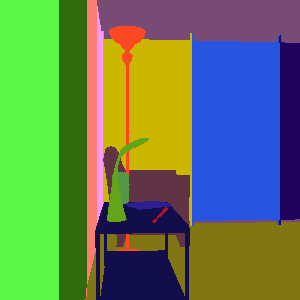

In [92]:
Image.fromarray(debug_simp.class_segmentation_frame)

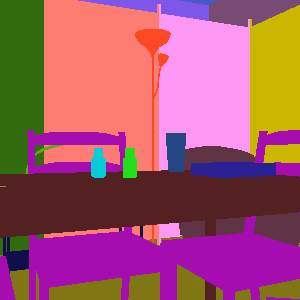

In [50]:
Image.fromarray(debug_simp.class_segmentation_frame)

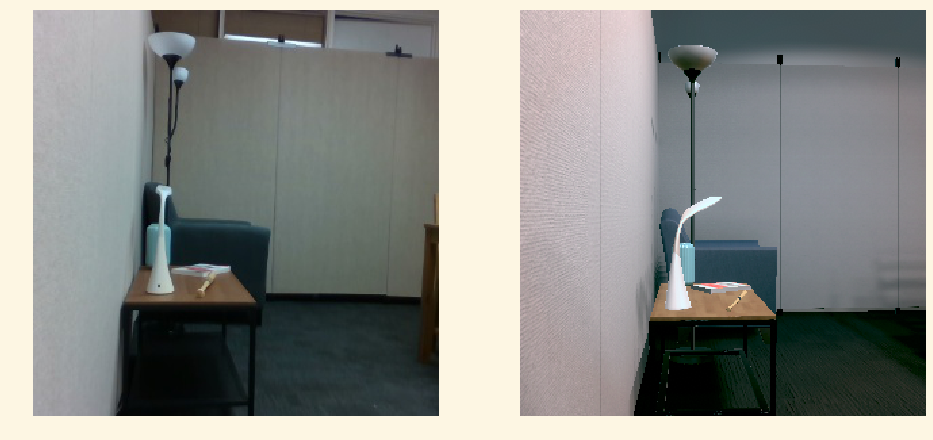

In [82]:
img_n, real_img_md = random.choice(list(real_md.items()))
real_img = load_real_img(img_n)

sim_img, debug_simp = get_thor_img_at_real_loc(scene_id, real_img_md)

show_side_by_side(real_img, sim_img)

In [ ]:
show_side_by_side

# explore depth

In [406]:
def get_thor_img_w_depth_at_real_loc(scene_id, real_md):
    sim_corr = get_sim_coords(real_md)
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.05, fieldOfView=42.5, renderDepthImage=True))
    sim_pos = teleport(sim_corr)
    depth_arr = sim_pos.depth_frame
    depth_arr = (255.0 / depth_arr.max() * (depth_arr - depth_arr.min())).astype(np.uint8)
    img_arr = sim_pos.cv2img
    depth_img = Image.fromarray(depth_arr)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img_arr)
    return img, depth_img

In [407]:
spec_point = {
    'agent': {'position': {"x": 2.662, "y": -1.683},
          'rotation': 90,
          'cameraHorizon': 0.5273437513344635},
         'scene': 'Val2_2'
}

In [408]:
sim_img, depth_img = get_thor_img_w_depth_at_real_loc(scene_id, spec_point)

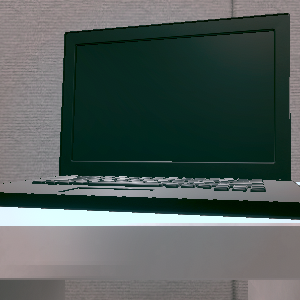

In [409]:
sim_img

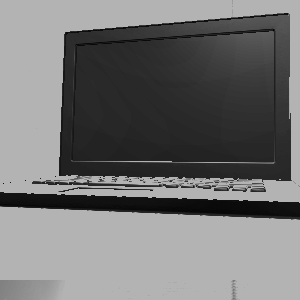

In [410]:
depth_img

In [533]:
def load_f(fn):
    with open(base_dir + fn) as f:
        rd = json.load(f)
        sd = rd['agent']['position']
        sd['rotation'] = rd['agent']['rotation']['y']
    return rd

In [534]:
alv_man_pos = [load_f(f) for f in man_pos_files]

In [538]:
alv_man_pos

[{'mobile_base_battery_percent': 100.0,
  'errorMessage': None,
  'agent': {'position': {'y': -1.684, 'x': 2.664, 'z': -1.782, 'rotation': 0},
   'rotation': {'y': 0, 'x': 0, 'z': 0.0},
   'cameraHorizon': 0.615234412130776,
   'odom': {'y': 0.0, 'x': 0.0, 'theta': 0.0},
   'bumper': False},
  'errorCode': None,
  'objects': [],
  'odom': {'y': 0.0, 'x': 0.0, 'theta': 0.0},
  'rotation': {'y': 0, 'x': 0, 'z': 0.0},
  'screenWidth': 300,
  'lastActionSuccess': True,
  'agentId': 0,
  'screenHeight': 300,
  'lastAction': 'Initialize',
  'bumper': False,
  'position': {'y': -1.684, 'x': 2.664, 'z': -1.782}},
 {'mobile_base_battery_percent': 100.0,
  'errorMessage': None,
  'agent': {'position': {'y': -1.693, 'x': 2.355, 'z': -1.81, 'rotation': 0},
   'rotation': {'y': 0, 'x': 0, 'z': 0.0},
   'cameraHorizon': 0.615234412130776,
   'odom': {'y': -0.0004647549067158252,
    'x': -0.298551470041275,
    'theta': -0.003839724464341998},
   'bumper': False},
  'errorCode': None,
  'objects': [

In [539]:
sim_coords = [get_sim_coords(im) for im in alv_man_pos]

In [ ]:
sim_

In [543]:
with open('sim_coords.json', 'w') as f:
    rd = json.dump( sim_coords, f, indent=3)